In [1]:
import os
import numpy as np
from collections import defaultdict

root = r'D:/20230428-Vince/models/'

data = {}
feature_names = []
for model in os.listdir(root):
    if os.path.exists(os.path.join(root, model, 'predict', 'prob')):
        feature_names.extend([f"{model}_prob{i}" for i in range(5)])
        for sample in os.listdir(os.path.join(root, model, 'predict', 'prob')):
            data.setdefault(sample, []).append(np.load(os.path.join(root, model, 'predict', 'prob', sample)))

for sample in data:
#     data[sample] = np.concatenate(data[sample], axis=0)
    data[sample] = np.reshape(np.transpose(np.concatenate(data[sample], axis=0), [1, 2, 0]), (-1, 20))
# data = np.load(r'D:/20230428-Vince/models/UNet/predict/prob/1010122479.npy')
# data.shape

In [5]:
from glob import glob
from PIL import Image

masks = glob(os.path.join(r'D:/20230428-Vince/train/masks/', '*.png')) + glob(os.path.join(r'D:/20230428-Vince/val/masks/', '*.png'))
masks = {os.path.basename(mask).replace('.png', '.npy'): np.reshape(np.array(Image.open(mask).resize((320, 320))), (-1))
         for mask in masks}

# 生成训练数据

In [6]:
num_use = 100
train_samples = [f.replace('.png', '.npy') for f in os.listdir(r'D:/20230428-Vince/train/images/')]
train_X_data = np.concatenate([data[s] for s in train_samples[:num_use]], axis=0)
train_y_data = np.concatenate([masks[s] for s in train_samples[:num_use]], axis=0)
train_y_data.shape

(10240000,)

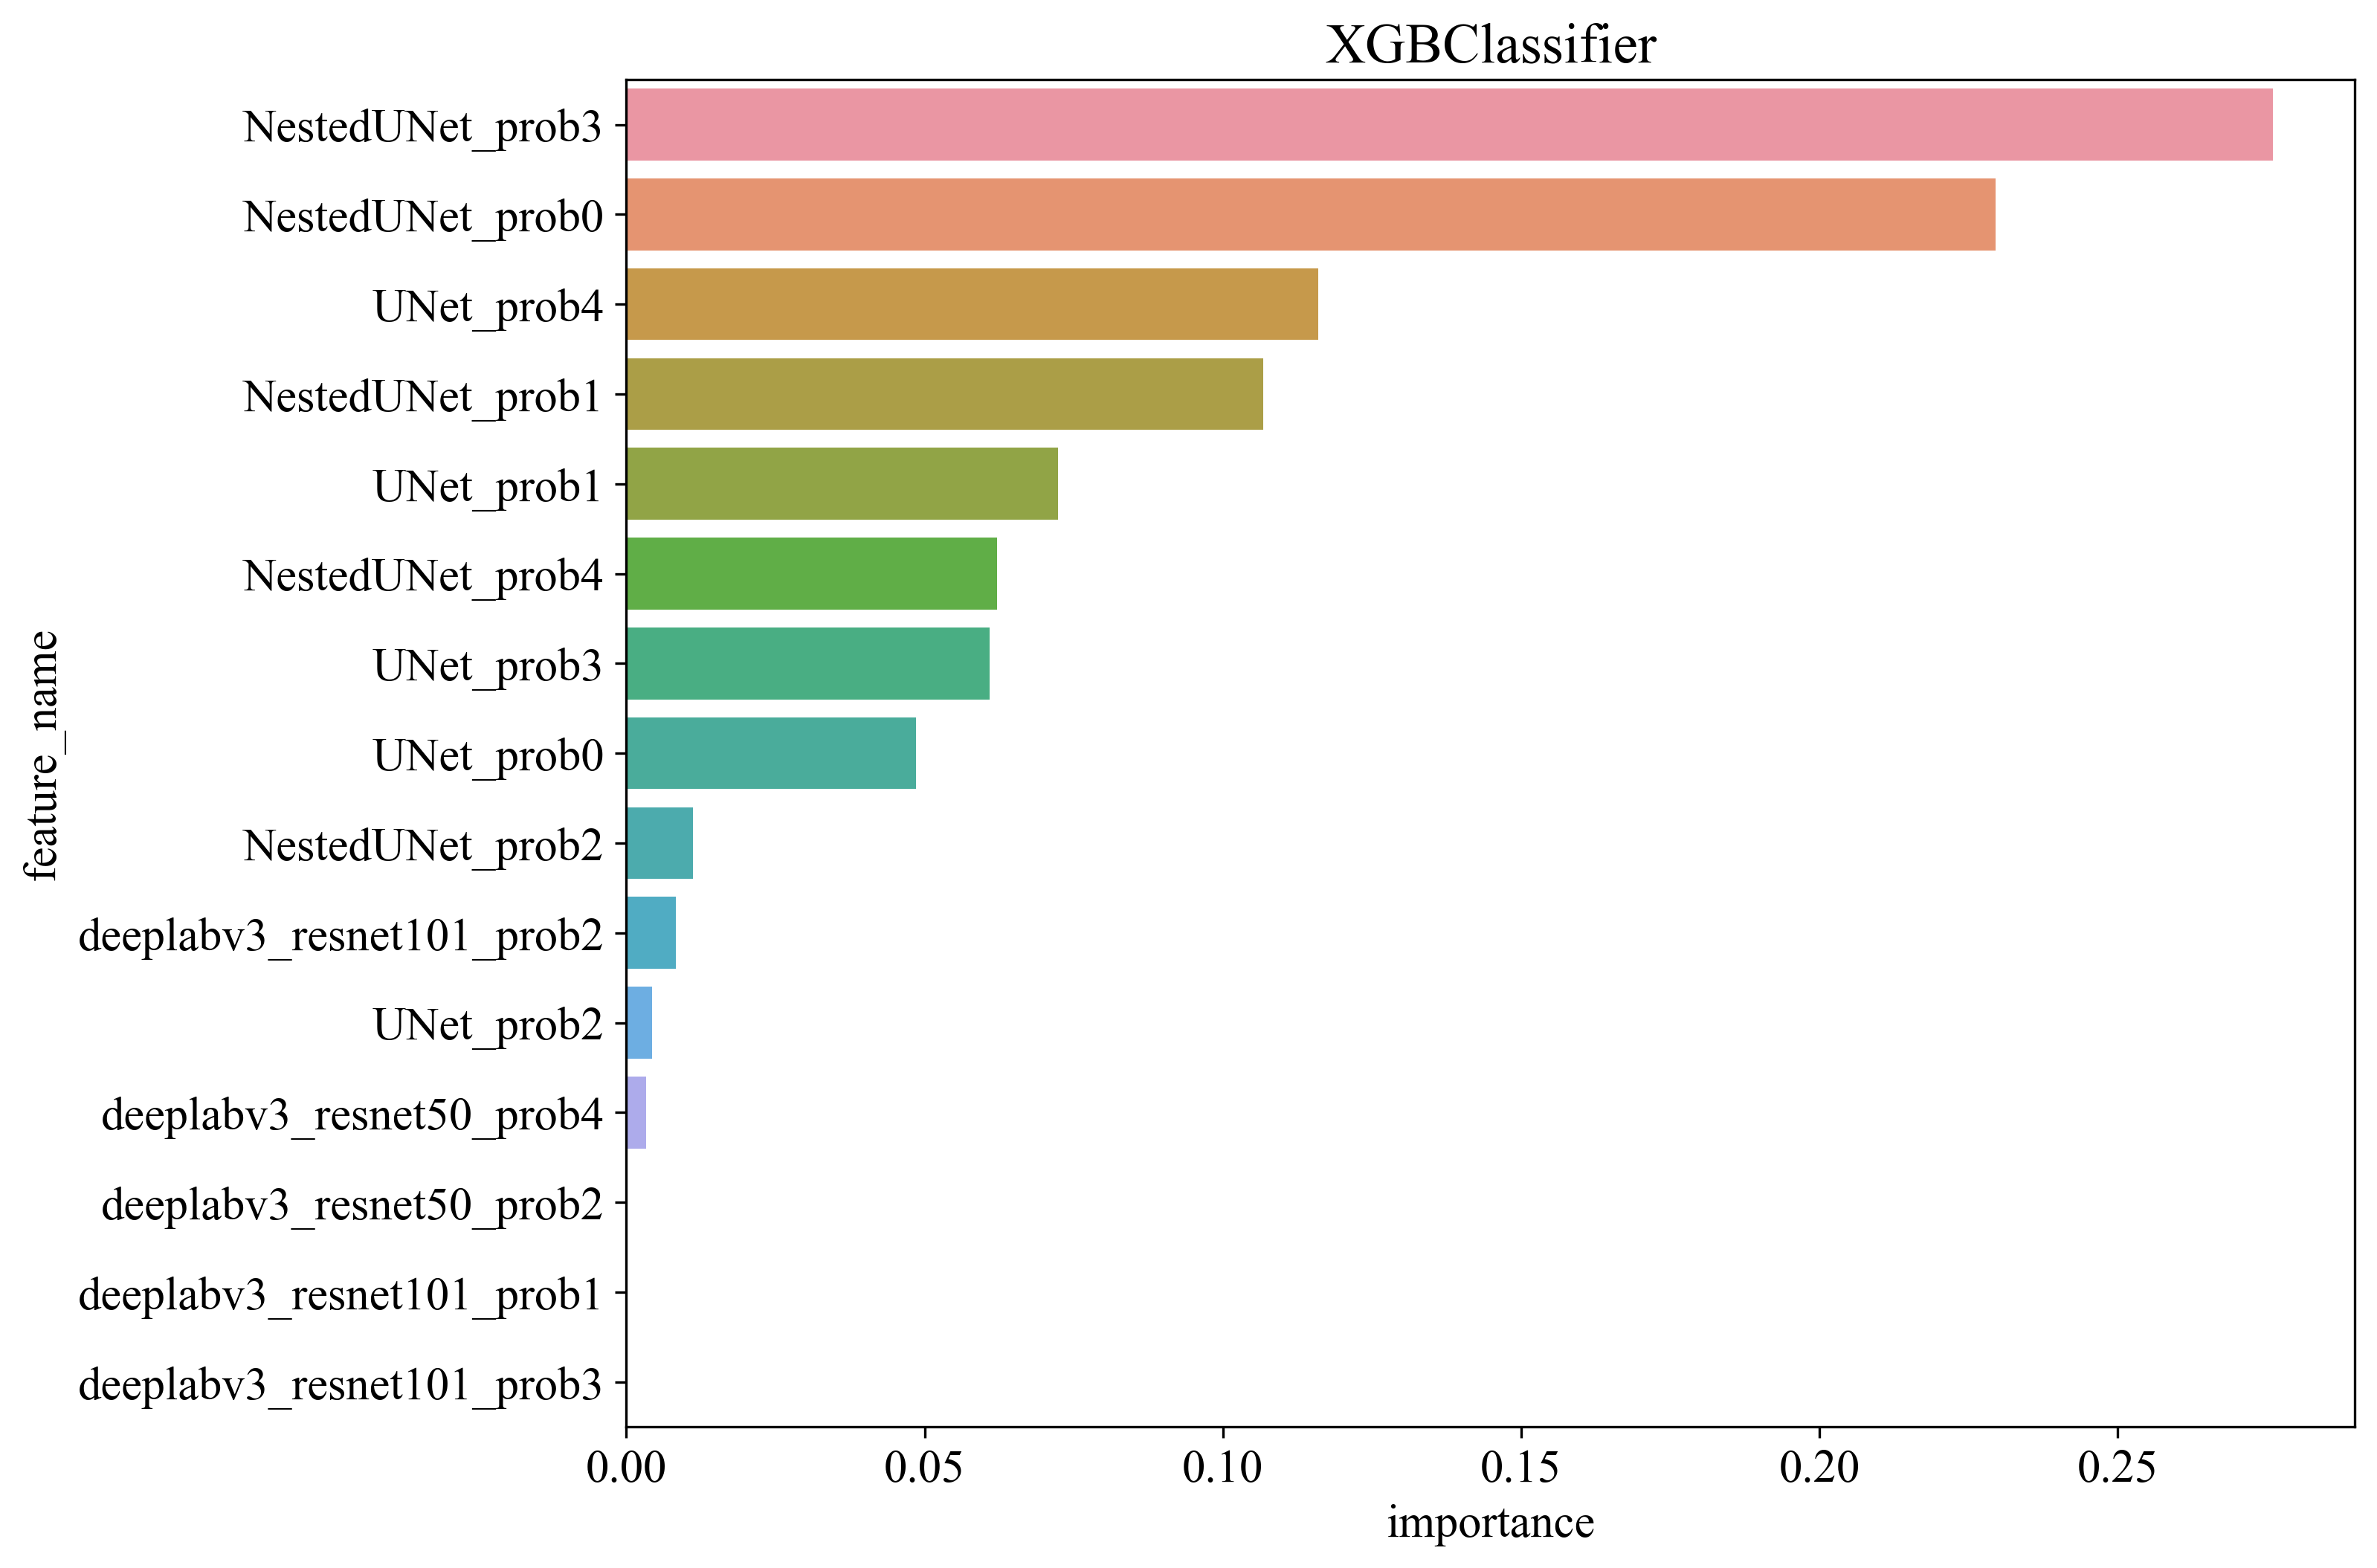

In [7]:
import joblib
from onekey_algo.custom.components.comp1 import plot_feature_importance, create_clf_model
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from onekey_algo import get_param_in_cwd
os.makedirs('models', exist_ok=True)
os.makedirs('img', exist_ok=True)

model_names = get_param_in_cwd('ml_models')
models = create_clf_model(model_names)
models['XGBoost'] = XGBClassifier(n_estimators=14, objective='binary:logistic', max_depth=2, #min_child_weight=0.2,
                                  use_label_encoder=False, eval_metric='error')
models = list(models.values())
for mn, m in zip(model_names, models):
    m.fit(train_X_data, train_y_data)
    # 保存训练的模型
    joblib.dump(m, f'models/Fusion_{mn}.pkl') 
    # 输出模型特征重要性，只针对高级树模型有用
    plot_feature_importance(m, feature_names, save_dir='img', prefix=f'Fusion_{mn}')

In [8]:
models[0] = joblib.load('models/Fusion_XGBoost_ALL.pkl')

# Fusion预测结果

In [9]:
from onekey_algo.utils.segmentation_utils import get_color_map_list
colors = np.array(get_color_map_list(5)).reshape(-1).tolist()

save_dir = r'D:/20230428-Vince/models/fusion'
os.makedirs(save_dir, exist_ok=True)
for sample in data:
    pred_img = Image.fromarray(np.reshape(models[0].predict(data[sample]).astype(np.uint8), (320, 320))).convert('P')
    pred_img.putpalette(colors)
    pred_img = pred_img.resize((512, 512))
    fname, ext = os.path.splitext(sample)
    pred_img.save(os.path.join(save_dir, f"{fname}.png"))

In [28]:
masks[sample]

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [24]:
np.sum(models[0].predict(data['1023501723.npy']) == masks['1023501723.npy'])

101076

In [21]:
models[2].predict_proba(data[sample])

array([[0.80309695, 0.08068401, 0.0124976 , 0.06148114, 0.04224025],
       [0.80309695, 0.08068401, 0.0124976 , 0.06148114, 0.04224025],
       [0.80309695, 0.08068401, 0.0124976 , 0.06148114, 0.04224025],
       ...,
       [0.8599658 , 0.04522853, 0.01410813, 0.04949449, 0.03120298],
       [0.8599658 , 0.04522853, 0.01410813, 0.04949449, 0.03120298],
       [0.79601425, 0.05574384, 0.01643044, 0.05764166, 0.07416987]],
      dtype=float32)

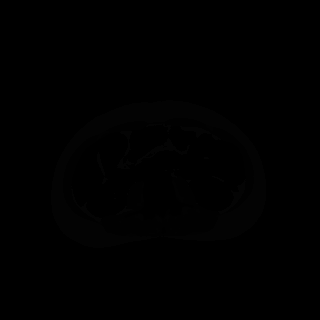

In [46]:
Image.fromarray(np.reshape(models[0].predict(data['1016431349.npy']).astype(np.uint8), (320, 320)))

In [35]:
np.argwhere(np.reshape(masks[sample], (320, 320)) == 4)

array([[109, 159],
       [109, 160],
       [109, 161],
       ...,
       [211, 220],
       [211, 221],
       [211, 222]], dtype=int64)

In [39]:
np.argwhere(masks[sample] == 4)

array([[35039],
       [35040],
       [35041],
       ...,
       [67740],
       [67741],
       [67742]], dtype=int64)

In [38]:
data[sample][:, 211, 220]

array([ 3.3956093e-01,  2.1974115e+00,  7.7585673e-01, -7.0047340e+00,
        2.2770438e+00,  6.3292235e-01,  2.3826609e+00,  1.1326752e+00,
       -5.7170520e+00,  2.2923574e+00,  2.8948487e-05,  5.1620384e-07,
        4.6094721e-03,  1.8830819e-05,  9.9534225e-01,  1.8244967e-04,
        7.7787968e-07,  2.0166247e-03,  4.6176232e-05,  9.9775404e-01],
      dtype=float32)

In [48]:
np.transpose(data[sample], [1, 2, 0]).shape

(320, 320, 20)

In [40]:
np.reshape(models[0].predict(data['1016431349.npy']), (320, 320))

(320, 320)

In [45]:
np.max(models[0].predict(data['1016431349.npy']).astype(int))

4